# Evaluating Classifiers

## Morning: Hard Classification Metrics, ROC Curves
- What are the metrics for evaluating a hard classifier?
- How is a ROC Curve constructed?

## Afternoon: Profit Curves, Resampling
- profit curves
- undersampling
- oversampling
- SMOTE

## Hard classifiers
Say we have a model that only predicts class membership: $0$ or $1$, nothing in between. 

So, for example, you have true labels
$$ y_{true} = [1, 0, 0, 1, 1, 0, 1, \ldots]$$

And predicted labels
$$ y_{pred} = [0, 0, 1, 1, 1, 0, 0, \ldots]$$

Sometimes you're right, sometimes you're wrong. Sometimes you called a horse a dog, sometimes you called a dog a horse. What kind of success & error metrics do we have?

### Confusion matrix

[wiki](https://en.wikipedia.org/wiki/Confusion_matrix)


|                    |Predicted positive|Predicted negative |
|--------------------|------------------|---------------|
| **Actual positive**| # of true positives (TP)    | # of false negatives (FN)|
| **Actual negative**| # of false positives (FP)   | # of true negatives (TN) |


### Classification metrics

n = # of data points

- Accuracy: fraction of data correctly classified
$$\text{Accuracy} = \frac{TP + TN}{n}$$
<br />
<br />

- True Positive Rate (aka **Sensitivity**, **Recall**):
fraction of actual positives that were labeled positive
$$\text{TPR} = \frac{TP}{TP + FN}$$
<br />
<br />

- True Negative Rate (**Specificity**):
fraction of actual negatives that were labeled negative
$$\text{TNR} = \frac{TN}{TN + FP}$$
<br />
<br />

- **Precision**: fraction of labeled positive points that were actually positive
$$\text{Precision} = \frac{TP}{TP + FP}$$
<br />
<br />

- False Positive Rate: fraction of actual negatives labeled as positive
$$\text{FPR} = \frac{FP}{TN + FP}$$
<br />
<br />

- False Negative Rate: fraction of actual positives labeled as negative
$$\text{FNR} = \frac{FN}{TP + FN}$$
<br />
<br />

- F-Score: a weighted harmonic mean of precision and recall
$$ F = \frac{1}{\alpha\frac{1}{precision} + (1-\alpha)\frac{1}{recall}}$$

- F1-Score ("balanced F-Score") has $\alpha=0.5$
$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$


### Exercise: credit card fraud prediction model

"positive" = "fraud"

"negative" = "not fraud"


|                    |Predicted positive|Predicted negative |
|--------------------|------------------|---------------|
| **Actual positive**| 4   | 10|
| **Actual negative**| 2  | 204 |

- Label each square with one of TP, FP, FN, TN.
- How many total data points do you have? How many are fraudulent? How many aren’t fraudulent?
- Calculate accuracy, precision and recall.


- Is the confusion matrix shown here representative of a good model?
- Which of the metrics you calculated above are most useful in determining how good the model is?
- What are cases where accuracy is useful? When do you need to be wary of using accuracy?


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

font = {'size'   : 16}
matplotlib.rc('font', **font)


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_curve, roc_auc_score

In [2]:
# LARGE DOGS AND SMALL HORSES
# MAY OR MAY NOT CORRESPOND TO ACTUAL EARTH MAMMAL DIMENSIONS

data = np.load('animals_big.npy')
X = data[:, :2]
y = data[:, 2]

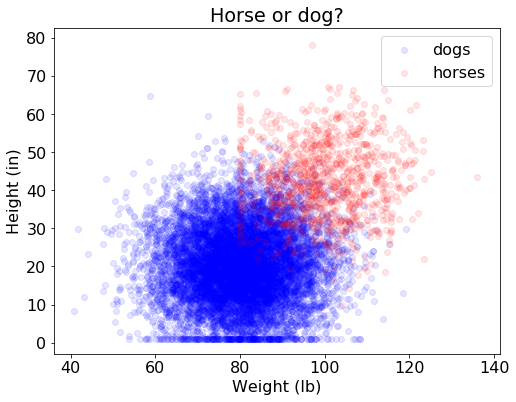

In [3]:
X_dogs = X[y == 0]
X_horses = X[y == 1]
y_dogs = y[ y== 0]
y_horses = y[ y== 1]

plt.figure(figsize=(8,6))
plt.scatter(X_dogs[:,0], X_dogs[:,1], color='b', label='dogs', alpha=0.1)
plt.scatter(X_horses[:,0], X_horses[:,1], color='r', label='horses', alpha= 0.1)
plt.legend()
plt.xlabel('Weight (lb)')
plt.ylabel('Height (in)')
plt.title('Horse or dog?')
plt.show()

In [4]:
y_horses.shape

(1000,)

In [5]:
y_dogs.shape

(10000,)

In [6]:
y_horses.shape[0] / (y.shape[0])

0.09090909090909091

## Logistic regression: the soft classifier

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
log_mod = LogisticRegression(C=1000)
log_mod.fit(X_train, y_train)
log_pred_prob_test = log_mod.predict_proba(X_test)[:,1]

In [9]:
log_loss(y_test, log_pred_prob_test)

0.090524359748359026

Log loss is something, but what if we want to turn our model into a hard classifier? We should pick a threshold $t$ and round all probabilities above $t$ to $1$, and all below it to $0$. But how do we pick $t$? Let's experiment.

Calling the `predict()` method picks $t=0.5$ for us.

In [10]:
log_pred = log_mod.predict(X_test)

In [11]:
# accuracy
np.mean(log_pred == y_test)

0.96690909090909094

In [12]:
# class balance
np.mean(y)

0.090909090909090912

$96\%$ seems like a high number, but note that only $9.09\%$ of the data is of the positive class (horses), so if we had a model that ***never predicted horse*** (barely a model at all!), it would have an accuracy score of $90.91\%$. Is the accuracy at $t=0.5$ that much better? Is there a better threshold to pick? What about the false positive rates and true positive rates, how do they change with threshold?

Let's see.

Max accuracy is 0.97 at threshold 0.4
Class balance is 0.091


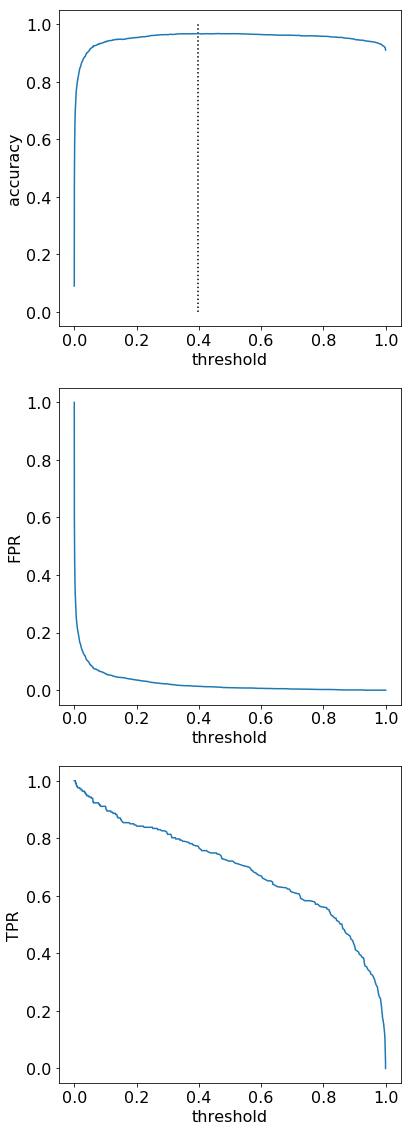

In [27]:
fig, axs = plt.subplots(3,1, figsize=(6,16))


accs = np.empty(log_pred_prob_test.shape)
fprs = np.empty(log_pred_prob_test.shape)
tprs = np.empty(log_pred_prob_test.shape)


thresholds = sorted(log_pred_prob_test)

for i,t in enumerate(thresholds):
    pred_y = log_pred_prob_test > t
    accs[i] = np.mean(pred_y == y_test)
    fprs[i] = np.mean(pred_y[y_test == 0])
    tprs[i] = np.mean(pred_y[y_test == 1])
    

for ax, arr, name in zip(axs.flatten(), 
                   [accs, fprs, tprs],
                   ['accuracy', 'FPR', 'TPR']):
    ax.plot(sorted(log_pred_prob_test), arr)
    ax.set_xlabel("threshold")
    ax.set_ylabel(name)

t_max_acc = thresholds[accs.argmax()]
axs[0].vlines(t_max_acc, 0, 1, color='k', linestyle=':')

plt.tight_layout()

print("Max accuracy is {:.2} at threshold {:.2}".format(accs.max(), t_max_acc))
print("Class balance is {:.2}".format(y.mean()))

## ROC Curve ("Receiver Operating Characteristic")

A plot of the TPR vs FPR at difference thresholds is called a ROC plot

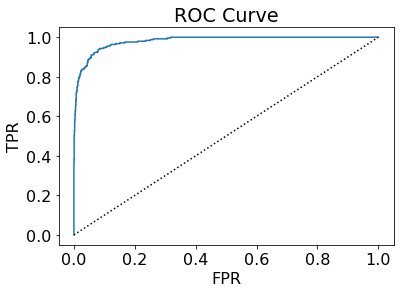

In [14]:
plt.plot(fprs, tprs)
plt.plot([0,1],[0,1], 'k:')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR");

fun gif: https://f-origin.hypotheses.org/wp-content/blogs.dir/253/files/2013/09/roc-anim-glm.gif

### Area under ROC curve (ROC AUC)

- The AUC (area under curve) is useful for comparing ROC curves.
  - It equals the probability that the model will rank a randomly chosen positive observation higher than a randomly chosen negative observation

In [15]:
roc_auc_score(y_test, log_pred_prob_test)

0.98081168993968371

### Comparing ROC curves
- If classifier A’s ROC curve is strictly greater than classifier B's, then A is preferred

In [16]:
knn_mod = KNeighborsClassifier(n_neighbors=5)
knn_mod.fit(X_train, y_train)
knn_pred = knn_mod.predict(X_test)
knn_pred_prob = knn_mod.predict_proba(X_test)[:,1]

In [17]:
(knn_pred == y_test).mean()

0.96109090909090911

In [18]:
log_loss(y_test, knn_pred_prob)

0.50653207197446926

In [19]:
knn_fprs, knn_tprs, knn_thresh = roc_curve(y_test, knn_pred_prob)

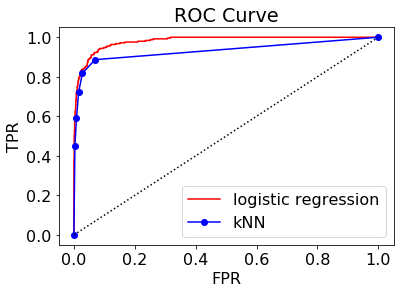

In [20]:
plt.plot(fprs, tprs, 
         label='logistic regression', 
         color='red')
plt.plot(knn_fprs, knn_tprs,
         label='kNN',
         marker='o', color='blue')
plt.plot([0,1],[0,1], 'k:')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve");

In [21]:
roc_auc_score(y_test, log_pred_prob_test)

0.98081168993968371

In [22]:
roc_auc_score(y_test, knn_pred_prob)

0.93085706059611062

The dotted line represents a random baseline. Let's make a truly dumb model: every point gets assigned a probability based on a draw from the uniform distribution from $0$ to $1$. 

In [23]:
dumb_probs = np.random.uniform(size=y_test.shape)

In [24]:
dumb_fprs, dumb_tprs, dumb_thresh = roc_curve(y_test, dumb_probs)

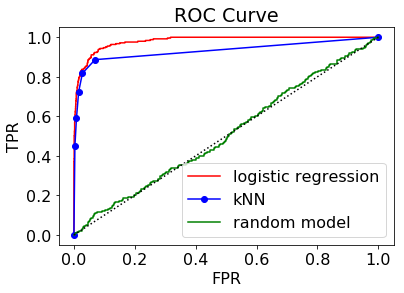

In [25]:
plt.plot(fprs, tprs, 
         label='logistic regression', 
         color='red')
plt.plot(knn_fprs, knn_tprs,
         label='kNN',
         marker='o', color='blue')
plt.plot(dumb_fprs, dumb_tprs,
         label='random model', 
         color='green')
plt.plot([0,1],[0,1], 'k:')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve");

In [26]:
roc_auc_score(y_test, dumb_probs)

0.50771624657698211

## Interpreting ROC curves

If two classifiers have ROC curves that intersect, then the choice depends on the relative importance of sensitivity (TPR) and specificity (TNR = 1 - FPR)

<img src="images/roc_int.png" width="300"></img>

#### Discussion:

When predicting credit card fraud, do we care more about optimizing TPR or FPR?

What is a scenario where our priorities are reversed?

#### Discussion

You have built 3 models to predict whether or not someone will default on a loan. You have 3000 data points and these features: age, gender, city, FICO score, highest education completed

- Which of the 3 ROC curves represents the model you should use?
- How would you pick between 50 models? 100 models? 1000 models?

<img src="images/roc_bad.png" width="500"></img>


#### Exercise

Construct a ROC curve only given the following predicted probabilities from a logistic regression and true labels

```
Predicted Probability | Actual Fraud?
-------------------------------------
    0.99              | Fraud
    0.84              | Fraud
    0.70              | Fraud
    0.70              | Not Fraud
    0.51              | Fraud
    0.22              | Fraud
    0.14              | Not Fraud
    0.05              | Not Fraud

```